# Quick perusal of the post-processed monte carlo output data

## Setup

In [1]:
# Imports
import pandas as pd
import numpy as np
# import scipy.io as spio
from os.path import join
from utils.mat_tools import matfile_struct_to_dict as mat2dict
from utils.mat_tools import extrapVentRadius
import pprint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt




In [2]:
# ---- Directories and files ----
data_dir = 'data/'

monte_carlo_fixed_vars_file = join(data_dir, 'fixed_MC_vars.mat')  # Simulation fixed input parameters
monte_carlo_rand_vars_file  = join(data_dir, 'rand_MC_vars.parquet') # Simulation randomized input parameters
monte_carlo_data_file       = join(data_dir, 'KatlaHydro_v8_noLd_2024-06-30_N20000.parquet')  # I/O data table for main parameters of interest, water depths up to 360 m
monte_carlo_scaled_file     = join(data_dir, 'KatlaHydro_v8_noLd_2024-06-30_N20000_scaled.parquet')  # data table for main parameters, scaled/non-dimensionalized
test_data_file              = join(data_dir, 'KatlaHydro_v8_noLd_2024-06-22_N10000.parquet') # Smaller test data set with water depths up to 500 m for testing

# ---- RF PARAMS ----
# Split siize
train_size = 0.2 # Small set for now
test_size  = 0.1

n_estimators = 100
max_depth    = 20
bootstrap    = True
oob_score    = True
n_jobs       = 2
min_samples_split = 2
# min_samples_leaf = 1
verbose = 1

## Data exploration and QC

In [3]:
# Load up data
monte_carlo_fixed_vars = mat2dict(monte_carlo_fixed_vars_file,'fixedVars')
monte_carlo_rand_vars  = pd.read_parquet(monte_carlo_rand_vars_file)
mc_df                  = pd.read_parquet(monte_carlo_data_file)
mc_df_scaled           = pd.read_parquet(monte_carlo_scaled_file)
mc_df_test             = pd.read_parquet(test_data_file)

In [4]:
# Check data overview
print('---> Fixed simulation input:\n\t')
pprint.pprint(monte_carlo_fixed_vars)
print('\n---> Randomized simulation input:\n\t', monte_carlo_rand_vars)
# monte_carlo_rand_vars.describe()
print('\n---> I/O data table:')
mc_df.info()
print(mc_df.describe())

print('\n---> Scaled data table:')
mc_df_scaled.info()

print('\n---> TEST data table:')
mc_df_test.info()


---> Fixed simulation input:
	
{'T_ec': array(273.15),
 'T_g': array(870, dtype=uint16),
 'T_g_rng': array(50, dtype=uint8),
 'Tw0': array(273.15),
 'atmo': array('C:\\Users\\crowell\\Kahuna\\data\\gvolc-meghan\\ERA5\\Katla_avg_atmo_Oct12_1979-2005.mat',
      dtype='<U81'),
 'phiFrag_mu': array(3, dtype=uint8),
 'phiFrag_sig': array(1.25),
 'proxy': array(1, dtype=uint8),
 'rho_melt': array(2600, dtype=uint16),
 'rho_rock': array(2800, dtype=uint16),
 'useDecompressLength': array(0, dtype=uint8),
 'vh0': array(850, dtype=uint16)}

---> Randomized simulation input:
	   Variable   Value 1   Value 2 Distribution Type
0        T  1375.000  1525.000           uniform
1       Zw     0.000   360.000           uniform
2      n_0     0.005     0.025           uniform
3     n_ec     0.000     0.200           uniform
4     logQ     6.000     8.000           uniform
5    a_var     1.000     0.150            normal
6        D     2.700     2.800          discrete

---> I/O data table:
<class 'pand

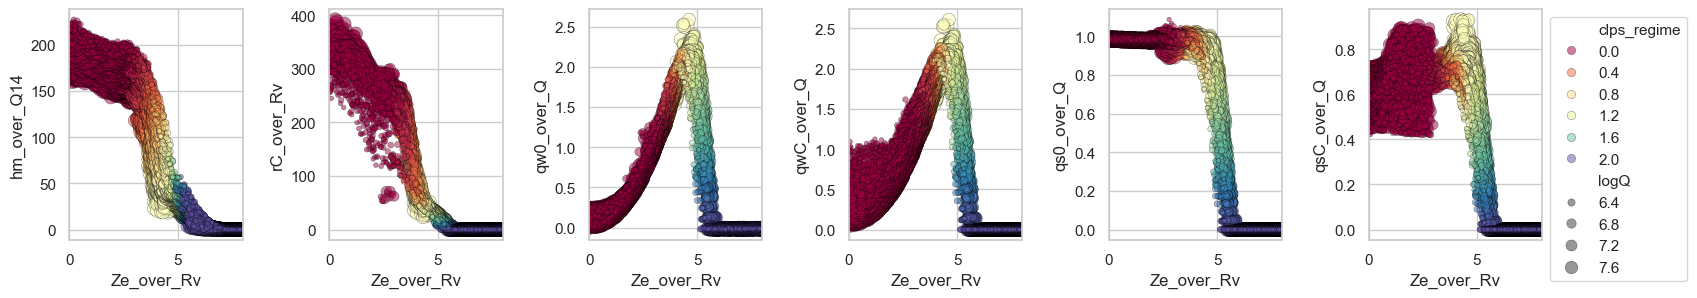

In [5]:
# Fill nans in the test set
mc_df_test['hm'] = mc_df_test['hm'].fillna(0.)

# Plot the scaled data set to better highlight physical relationships with water depth, Ze
%matplotlib inline
mc_df['n_total'] = mc_df['n_0'] + mc_df['n_ec']

# Make a few descriptive plots of the dataset
input_vars = ['Ze_over_Rv'] #,'logQ','n_total','a_over_Rv','T'] # monte_carlo_rand_vars['Variable']
output_vars = ['hm_over_Q14','rC_over_Rv','qw0_over_Q','qwC_over_Q','qs0_over_Q','qsC_over_Q']

sns.set_theme(style="whitegrid")
# sns.pairplot(mc_df_scaled, vars=output_vars, hue="clps_regime")
#sns.pairplot(mc_df_scaled, x_vars=input_vars, y_vars=output_vars, hue="clps_regime")

fig,axes = plt.subplots(1,len(output_vars), figsize=(19,3),gridspec_kw={'wspace':0.5})
for ax,var in zip(axes,output_vars):
    if ax==axes[len(axes)-1]:
        show_legend = True
    else:
        show_legend = False  
    sns.scatterplot(x="Ze_over_Rv",y=var,
                hue='clps_regime',
                size='logQ',
                sizes=(10, 100),
                data=mc_df_scaled.sort_values('logQ',ascending=False), 
                alpha=0.5,
                palette="Spectral", 
                edgecolors=[0, 0, 0],
                ax=ax, 
                legend=show_legend) #"ch:r=-.2,d=.3_r") #, edgecolors=[0, 0, 0])
    
    ax.set_xlim(left=0., right=8.,)

sns.move_legend(axes[-1], "upper left", bbox_to_anchor=(1, 1))
plt.show()

## Build Random Forest

In [6]:
# ---- Create feature inputs for random forest ----
# We will train on the UNscaled data set, since we want to random forest to learn the relationships

# Get logQ (log10 of mass flux) and n_total (total water vapor mass fraction) from the scaled data set

# Setup input/output variables - the last three are tacked on for now but unlikely to be very important
X_train = pd.concat([mc_df_scaled['logQ'], mc_df['Ze'], mc_df_scaled[['n_total','a_over_Rv']], mc_df[['T','D']]], axis=1)
Y_train = mc_df[['hm', 'qs0', 'qsC', 'rC', 'qw0', 'qwC']]

# For test data, we don't have the pre-built scaled data so need to quickly build a couple fields
logQ_test         = np.log10(mc_df_test['Q'])
n_total_test      = mc_df_test['n_0'] + mc_df_test['n_ec']
a_over_Rv         = mc_df_test['conduit_radius'] / extrapVentRadius(mc_df_test['Q']) # Normally randomized vent radius scaled to a standard vent radius
logQ_test.name, n_total_test.name, a_over_Rv.name    = 'logQ', 'a_over_Rv', 'n_total'

# Build the test data frames
X_test = pd.concat([logQ_test, mc_df_test['Ze'], n_total_test, a_over_Rv, mc_df_test[['T','D']]],axis=1)
Y_test = mc_df_test[['hm', 'qs0', 'qsC', 'rC', 'qw0', 'qwC']]

# X_train.info()
# Y_train.info()
# X_test.info()
# Y_test.info()

# Train/Test split
#X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size = train_size, test_size = test_size, random_state=42)
#X_train.shape, X_test.shape

In [7]:
# ---- Build classifier and train initial random forest ----
regressor_rf = RandomForestRegressor(n_estimators=n_estimators, 
                                     max_depth=max_depth,
                                     bootstrap=bootstrap, 
                                     oob_score=oob_score,
                                     n_jobs=n_jobs,
                                     min_samples_split=min_samples_split,
                                     random_state=0,
                                     verbose=verbose)


regressor_rf.fit(X_train,Y_train)

# Get scores and initial predictions
regressor_rf.oob_score_

# predictions = regressor_rf.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    8.6s finished


0.9978950913165264

Text(0.5, 1.0, 'Visualizing Feature Importances')

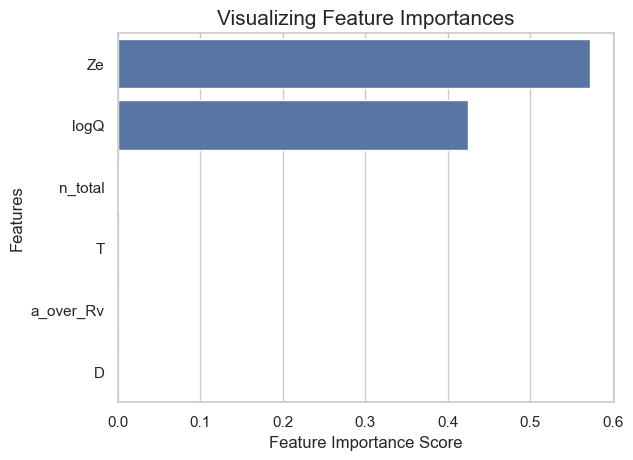

In [8]:
# making the feature importances plot
feature_imp = pd.Series(regressor_rf.feature_importances_, 
                        index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)


# Run predictions, calc result score
# Plots

Not too surprisingly, only Ze and logQ register as important, the other variables are largely producing minor noise in this context

In [9]:
# Slimmed down training and test X, then re-train
X_train = X_train[['Ze','logQ']]
X_test  = X_test[['Ze','logQ']]

regressor_rf.fit(X_train,Y_train)

# Get scores and initial predictions
regressor_rf.oob_score_
predictions = regressor_rf.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [25]:
mc_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   T               10000 non-null  float64
 1   Ze              10000 non-null  float64
 2   n_0             10000 non-null  float64
 3   n_ec            10000 non-null  float64
 4   Q               10000 non-null  float64
 5   conduit_radius  10000 non-null  float64
 6   D               10000 non-null  float64
 7   clps_regime     10000 non-null  float64
 8   hm              10000 non-null  float64
 9   qs0             10000 non-null  float64
 10  qsC             10000 non-null  float64
 11  rC              10000 non-null  float64
 12  qw0             10000 non-null  float64
 13  qwC             10000 non-null  float64
dtypes: float64(14)
memory usage: 1.1 MB


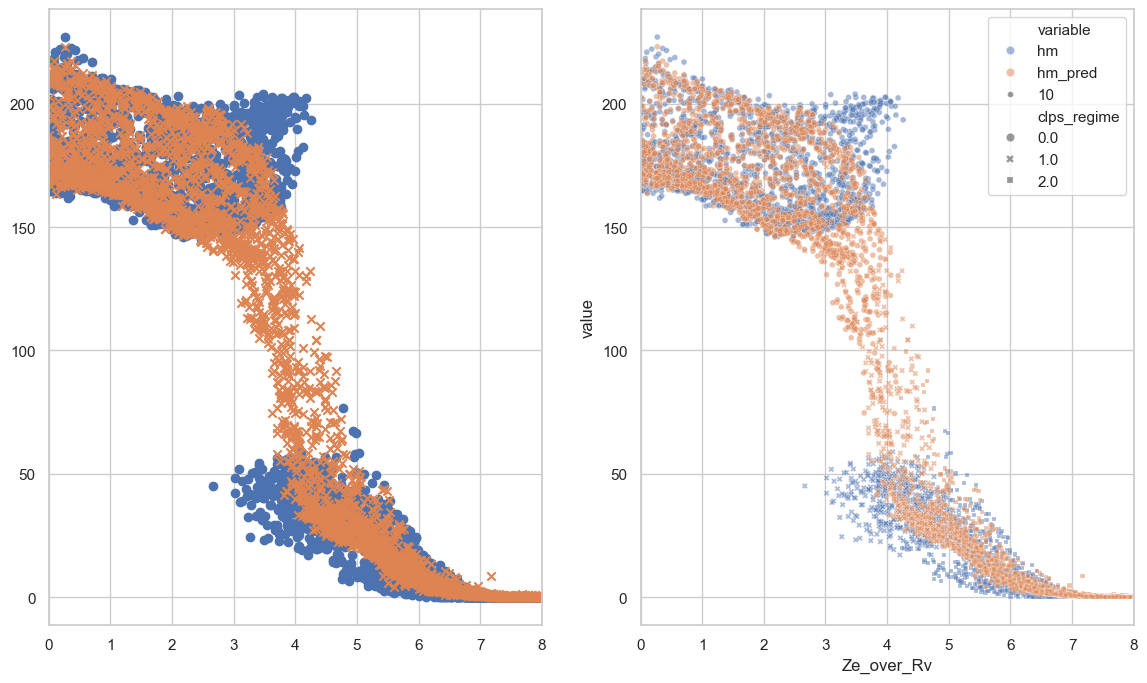

In [117]:

df_predict = pd.DataFrame(data=predictions, columns=[var+'_pred' for var in Y_train.columns])
# df_predict.info()

df_test_predict = pd.concat([Y_test, df_predict], axis=1)
# df_test_predict.info()

# Y_test.columns

# Get scaled prediction set for clear plots
# For test data, we don't have the pre-built scaled data so need to quickly build a couple fields
df_predict_scaled = df_predict.copy()

df_predict_scaled['logQ'] = np.log10(mc_df_test['Q'])
df_predict_scaled['Ze_over_Rv'] = mc_df_test['Ze'] / extrapVentRadius(mc_df_test['Q'])

# df_predict_scaled['hm_pred'] /= mc_df_test['Q']**(1/4)
df_predict_scaled[['hm_pred','rC_pred']] = df_predict_scaled[['hm_pred','rC_pred']].div(mc_df_test['Q']**(1/4),axis=0)
df_predict_scaled[['qw0_pred','qwC_pred','qs0_pred','qsC_pred']] = df_predict_scaled[['qw0_pred','qwC_pred','qs0_pred','qsC_pred']].div(mc_df_test['Q'], axis=0)

df_predict_scaled = df_predict_scaled.assign(**{col: mc_df_test[col] / mc_df_test['Q']**(1/4) for col in ['hm','rC']})
df_predict_scaled = df_predict_scaled.assign(**{col: mc_df_test[col] / mc_df_test['Q'] for col in ['qw0','qwC','qs0','qsC']})


# df_predict_scaled.info()
# df_predict_scaled[['hm_pred','rC_pred']][0:10]

# n_total_test       = mc_df_test['n_0'] + mc_df_test['n_ec']
# a_over_Rv          = mc_df_test['conduit_radius'] / extrapVentRadius(mc_df_test['Q']) # Normally randomized vent radius scaled to a standard vent radius
# logQ_test.name, n_total_test.name, a_over_Rv.name    = 'logQ', 'a_over_Rv', 'n_total'

fig,ax = plt.subplots(1, 2, figsize=(14,8))
ax[0].scatter(df_predict_scaled['Ze_over_Rv'],df_predict_scaled['hm'])
ax[0].scatter(df_predict_scaled['Ze_over_Rv'],df_predict_scaled['hm_pred'],marker='x')
ax[0].set_xlim([0.,8.])

test_df = pd.melt( df_predict_scaled[['Ze_over_Rv','hm', 'hm_pred']], id_vars='Ze_over_Rv', value_vars= ['hm', 'hm_pred'])
test_df2 = df_predict_scaled[['Ze_over_Rv','hm', 'hm_pred']]

# Plot physical relationships to see what's happening
sns.scatterplot(
            data= test_df , 
            # data=test_df2,
            x='Ze_over_Rv',
            y='value',
            hue='variable', #pd.concat([mc_df_test['clps_regime']]*2, ignore_index=True),
            style=pd.concat([mc_df_test['clps_regime']]*2, ignore_index=True), #'variable',
            size=10,
            # # sizes=(10, 100),
            alpha=0.5,
            # palette="ch:r=-.2,d=.3_r", #'coolwarm', #sns.color_palette("icefire", as_cmap=True),  #"Spectral", 
            # edgecolors=None,
            # ax=ax[1], 
            # legend=show_legend
            ) 
ax[1].set_xlim(0., 8.,)

plt.show()

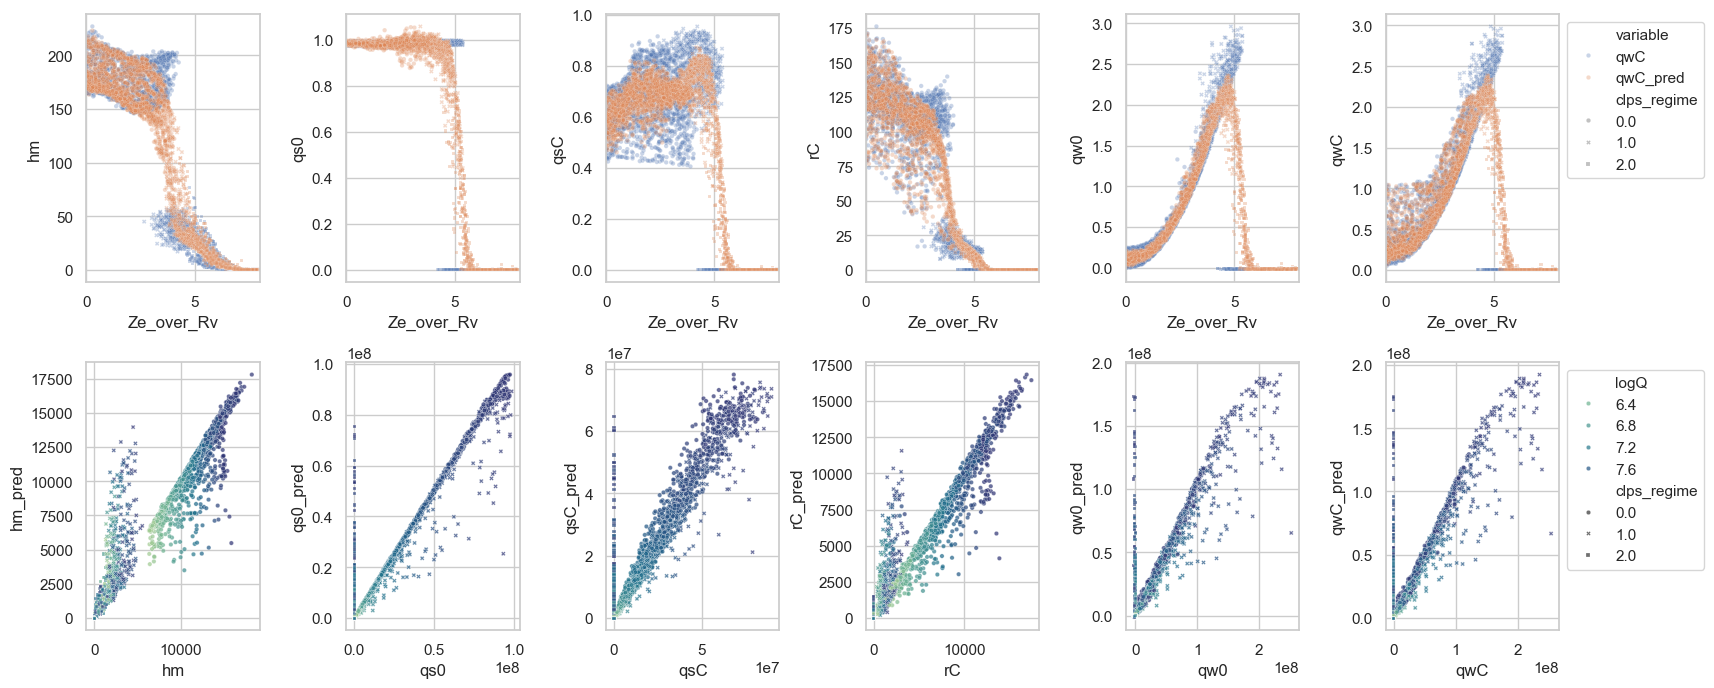

In [142]:
# Make plots
n_cols = len(Y_test.columns)
n_rows = 2

fig,axes = plt.subplots(n_rows, n_cols, figsize=(19,8),gridspec_kw={'wspace':0.5, 'hspace':0.3})


for ai,var in enumerate(Y_test.columns):
    if ai==n_cols-1:
        show_legend = True
    else:
        show_legend = False  

    # test_df = pd.melt( df_predict_scaled[['Ze_over_Rv',var, var+'_pred']], id_vars='Ze_over_Rv', value_vars= [var, var+'_pred'])
    # print(test_df.shape)
    # print(test_df.info())
    
    # Plot physical relationships to see what's happening
    sns.scatterplot(
                data= pd.melt( df_predict_scaled[['Ze_over_Rv',var, var+'_pred']], id_vars='Ze_over_Rv', value_vars= [var, var+'_pred']) , 
                # data= pd.melt( df_predict_scaled[['Ze_over_Rv',var]], id_vars='Ze_over_Rv', value_vars= [var]) , 
                # data= pd.melt( df_predict_scaled[['Ze_over_Rv',var+'_pred']], id_vars='Ze_over_Rv', value_vars= [var+'_pred']) , 
                x='Ze_over_Rv',
                y='value',
                hue='variable', #pd.concat([mc_df_test['clps_regime']]*2, ignore_index=True),
                style=pd.concat([mc_df_test['clps_regime']]*2, ignore_index=True), #'variable',
                # size=5,
                # sizes=3,
                alpha=0.3,
                # palette=sns.diverging_palette(250, 30, l=65, center="dark", n=2), #"ch:r=-.2,d=.3_r", #sns.color_palette("icefire", as_cmap=True),  #"Spectral", 
                # edgecolors=[0, 0, 0],
                ax=axes[0,ai], 
                legend=show_legend,
                s=10
    ) #"ch:r=-.2,d=.3_r") #, edgecolors=[0, 0, 0])
    
    axes[0,ai].set_xlim(left=0., right=8.,)
    axes[0,ai].set_ylabel(var)
sns.move_legend(axes[0,-1], "upper left", bbox_to_anchor=(1, 1))
    
for ai,var in enumerate(Y_test.columns):
    if ai==n_cols-1:
        show_legend = True
    else:
        show_legend = False 
    # Plot predictions against test set ground truth
    sns.scatterplot(data=df_test_predict, 
                x=var,y=var+'_pred',
                style=mc_df_test['clps_regime'],
                hue=df_predict_scaled['logQ'],
                s=10,
                # sizes=3,
                alpha=0.7,
                palette="crest", 
                # edgecolors=[0, 0, 0],
                ax=axes[1,ai], 
                legend=show_legend) #"ch:r=-.2,d=.3_r") #, edgecolors=[0, 0, 0])
    
    # ax.set_xlim(left=0., right=8.,)

sns.move_legend(axes[1,-1], "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [22]:
df_test_predict[['hm','hm_pred','rC','rC_pred','qw0','qw0_pred']][0:10]
# df_test_predict['hm_pred'][0:10]

,hm,hm_pred,rC,rC_pred,qw0,qw0_pred
0,0.000000,0.133361,0.000000,0.000000,-6.195367e+05,-3.686073e+05
1,13673.652974,13219.362875,10620.995240,10071.423559,4.833590e+07,4.904166e+07
2,0.000000,8.616757,0.000000,0.000000,-4.191114e+05,-8.184071e+05
3,12180.952546,10979.810662,8435.460933,7486.145645,2.899526e+07,3.091586e+07
4,13.486163,61.963546,0.000000,0.000000,-1.052270e+05,-1.574939e+05
5,11208.550574,11250.830551,7345.284060,7363.522705,4.421322e+06,4.944924e+06
6,0.000000,0.001282,0.000000,0.000000,-8.507324e+05,-9.386711e+05
7,0.000000,0.000000,0.000000,0.000000,-9.612266e+04,-1.894693e+05
8,0.000000,0.000000,0.000000,0.000000,-7.980852e+03,-2.432131e+04
9,0.000000,0.651617,0.000000,0.000000,-3.791475e+05,-3.612063e+05


## Run a couple tests with fixed mass flux Q, and varying water depth Ze, simulating the real use case

In [ ]:
Q_vector = [1e6 5e6 1e7 3e7] # Span over an order of magnitude in mass flux

nnn = 201
t = np.linspace(0,10,nn) # Build a dummy time vector

# Use a simple exponential function to make a proxy Ze evolution over an arbitrary timescale
tau = 1.
y = t * np.exp(1 - t/tau)
Ze_max = [30 60 120 180]

# Make a plot
n_rows = len(Ze_max)
n_cols = len(Y_test.columns)
fig,axes = plt.subplots(2, n_cols, figsize=(19,8),gridspec_kw={'wspace':0.5, 'hspace':0.3})

# Calculate errors